# Baseline model

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from hms.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, DropoutLayer, BatchNormalizationLayer
from hms.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError, L1Error
from hms.models import SingleLayerModel, MultipleLayerModel
from hms.initialisers import UniformInit, GlorotUniformInit, ConstantInit
from hms.learning_rules import GradientDescentLearningRule, AdamLearningRule
from hms.data_providers import HMSDataProvider
from hms.optimisers import Optimiser
from hms.penalties import L1Penalty, L2Penalty
import seaborn as sns;
from scipy.fftpack import fft, dct


%matplotlib inline
plt.style.use('ggplot')

In [164]:
# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = HMSDataProvider('train', 'extro', 'Twitter', rng=rng)
valid_data = HMSDataProvider('validation', 'extro', 'Twitter', rng=rng)
input_dim, output_dim = 100, 6

In [165]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.001  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats
hidden_dim = 40
incl_prob = 0.5

weights_penalty_1 = L1Penalty(1e-1)
weights_penalty_2 = L2Penalty(5e-4)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
# param_init = UniformInit(-init_scale, init_scale, rng=rng)

weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create affine + softmax model
model = MultipleLayerModel([
    #DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty_2),
    #BatchNormalizationLayer(input_dim = hidden_dim),
    ReluLayer(),
    #DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty_2),
])

# Initialise a cross entropy error object
error = SumOfSquaredDiffsError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

# stats, keys, run_time, fig_1, ax_1 = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Epoch Progress: 100%|██████████| 4868/4868 [00:08<00:00, 592.51it/s]Epoch 1: 8.2s to complete
    error(train)=3.88e-02, acc(train)=3.64e-01, error(valid)=7.95e-02, acc(valid)=5.73e-01
Epoch Progress:  88%|████████▊ | 4264/4868 [00:05<00:00, 938.26it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:06<00:00, 802.10it/s] Epoch 2: 6.1s to complete
    error(train)=3.79e-02, acc(train)=3.73e-01, error(valid)=7.87e-02, acc(valid)=5.59e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1057.92it/s]Epoch 3: 4.6s to complete
    error(train)=3.77e-02, acc(train)=3.75e-01, error(valid)=7.87e-02, acc(valid)=5.76e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:05<00:00, 880.35it/s]Epoch 4: 5.6s to complete
    error(train)=3.77e-02, acc(train)=3.77e-01, error(valid)=7.95e-02, acc(valid)=5.52e-01
Epoch Progress:  15%|█▌        | 752/4868 [00:00<00:04, 856.00it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:11<00:00, 436.45it/s]Epoch 5: 11.2s to complete
    error(train)=3.77e-02, acc(train)=3.77e-01, error(valid)=7.77e-02, acc(valid)=5.88e-01
Epoch Progress:  20%|█▉        | 971/4868 [00:02<00:10, 359.96it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:11<00:00, 430.48it/s]Epoch 6: 11.3s to complete
    error(train)=3.77e-02, acc(train)=3.69e-01, error(valid)=8.06e-02, acc(valid)=5.17e-01
Epoch Progress:  41%|████▏     | 2015/4868 [00:03<00:04, 673.38it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:06<00:00, 717.75it/s]Epoch 7: 6.8s to complete
    error(train)=3.75e-02, acc(train)=3.76e-01, error(valid)=7.90e-02, acc(valid)=5.57e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:06<00:00, 758.66it/s]Epoch 8: 6.4s to complete
    error(train)=3.77e-02, acc(train)=3.76e-01, error(valid)=7.83e-02, acc(valid)=5.65e-01
Epoch Progress:  29%|██▉       | 1410/4868 [00:01<00:04, 813.67it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:05<00:00, 818.42it/s]Epoch 9: 6.0s to complete
    error(train)=3.75e-02, acc(train)=3.78e-01, error(valid)=7.90e-02, acc(valid)=5.61e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:05<00:00, 937.20it/s] Epoch 10: 5.2s to complete
    error(train)=3.76e-02, acc(train)=3.77e-01, error(valid)=7.91e-02, acc(valid)=5.53e-01
Epoch Progress:  51%|█████     | 2479/4868 [00:02<00:02, 1086.79it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1011.72it/s]Epoch 11: 4.8s to complete
    error(train)=3.76e-02, acc(train)=3.76e-01, error(valid)=7.84e-02, acc(valid)=5.67e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1027.91it/s]Epoch 12: 4.8s to complete
    error(train)=3.76e-02, acc(train)=3.76e-01, error(valid)=7.99e-02, acc(valid)=5.48e-01
Epoch Progress:  94%|█████████▎| 4560/4868 [00:04<00:00, 1094.41it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 984.15it/s] Epoch 13: 5.0s to complete
    error(train)=3.75e-02, acc(train)=3.79e-01, error(valid)=7.86e-02, acc(valid)=5.70e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1009.60it/s]Epoch 14: 4.9s to complete
    error(train)=3.76e-02, acc(train)=3.79e-01, error(valid)=7.80e-02, acc(valid)=5.74e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 982.60it/s]Epoch 15: 5.0s to complete
    error(train)=3.75e-02, acc(train)=3.77e-01, error(valid)=7.92e-02, acc(valid)=5.51e-01
Epoch Progress:  28%|██▊       | 1387/4868 [00:01<00:03, 1062.97it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1057.71it/s]Epoch 16: 4.6s to complete
    error(train)=3.76e-02, acc(train)=3.75e-01, error(valid)=7.88e-02, acc(valid)=5.59e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:04<00:00, 1010.79it/s]Epoch 17: 4.8s to complete
    error(train)=3.76e-02, acc(train)=3.78e-01, error(valid)=7.84e-02, acc(valid)=5.76e-01
Epoch Progress:  66%|██████▌   | 3198/4868 [00:03<00:03, 451.18it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:06<00:00, 785.14it/s]Epoch 18: 6.2s to complete
    error(train)=3.76e-02, acc(train)=3.75e-01, error(valid)=7.76e-02, acc(valid)=5.79e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:07<00:00, 664.19it/s]Epoch 19: 7.4s to complete
    error(train)=3.75e-02, acc(train)=3.78e-01, error(valid)=7.87e-02, acc(valid)=5.52e-01
Epoch Progress:  33%|███▎      | 1625/4868 [00:02<00:04, 684.27it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:06<00:00, 704.83it/s]Epoch 20: 6.9s to complete
    error(train)=3.75e-02, acc(train)=3.76e-01, error(valid)=7.89e-02, acc(valid)=5.59e-01
Experiment Progress: 100%|██████████| 20/20 [02:56<00:00,  8.77s/it]


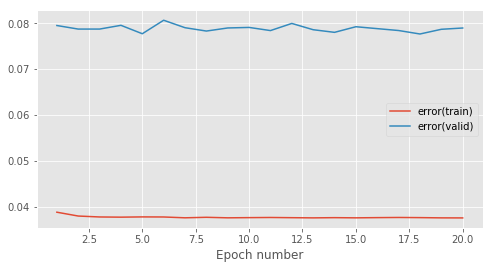

In [166]:
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

## Visualize validation set prediction

In [154]:
motion_data = np.load('data/Twitter/validation_extro.npz')['targets']
print("Motion length: ", motion_data.shape[0])
result, evaluation = optimiser.eval_test_set(valid_data, 'validation')
prediction = result[-1]
print('Error:    ' + str(evaluation['errorvalidation']))

Motion length:  73381
Error:    5.12593823184e-05


In [155]:
evaluation

OrderedDict([('errorvalidation', 5.1259382318394552e-05),
             ('accvalidation', 0.00030283552699303064)])

In [156]:
prediction_smooth = smooth_prediction(prediction)
prediction_smooth = dct_smoothing(prediction_smooth[:30000,:], 10000)

TypeError: dct_smoothing() missing 1 required positional argument: 'window_size'

In [ ]:
# Two subplots, the axes array is 1-d
# trail = prediction[0:5000,0]
# trail_freq = np.zeros(trail.shape)
# trail_freq[:500] = dct(trail, norm="ortho")[:500]
# trail_smooth = dct(trail_freq, 3, norm="ortho")

f, axarr = plt.subplots(4, sharex=True, figsize=(17,8))
axarr[0].plot(motion_data[:30000,0], color = 'cadetblue')
axarr[0].set_title('Actual motion data')
axarr[1].plot(prediction[:30000,0], color = 'cadetblue')
axarr[1].set_title('Raw prediction')

# First smoothing, naive
prediction_smooth = smooth_prediction(prediction)
axarr[2].plot(prediction_smooth[:30000,0], color = 'cadetblue')
axarr[2].set_title('Smoothed prediction')

# Second smoothing, dct
prediction_dct = dct_smoothing(prediction_smooth, 1000)
axarr[3].plot(prediction_dct[:30000,0], color = 'cadetblue')
axarr[3].set_title('DCT smoothed prediction')
plt.suptitle('Validation, comparison on dimention 1', size = 20)
plt.show()

### Calculate Correlation Coefficient of validation set prediction and actual motion

CC of dimension 0  is  -0.000235361667518
CC of dimension 1  is  -0.00241371584752
CC of dimension 2  is  0.000443293582792
CC of dimension 3  is  0.00267970983069
CC of dimension 4  is  0.000421811872153
CC of dimension 5  is  -0.00139990946232


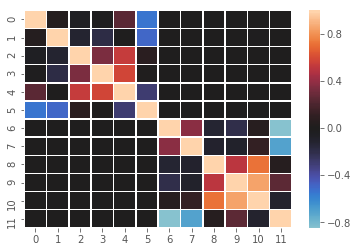

In [43]:
motion_transpose = np.array(motion_data.transpose())
prediction_transpose = np.array(prediction_dct.transpose())

pearson_correlation_coefficient = np.corrcoef(motion_transpose[:6], prediction_transpose[:6])
sns.heatmap(pearson_correlation_coefficient, center=0, linewidths=.5)

for i in range(6):
    print("CC of dimension {}".format(i), " is ", pearson_correlation_coefficient[i,i+6])

## Define a function that smooths the output

In [167]:
def smooth_prediction(raw_prediction):
    output_shape = raw_prediction.shape
    # make a matrix that adds 20 lines paddings at the beginning & end of raw prediction
    calculation_frame = np.zeros((output_shape[0]+40, output_shape[1]))
    output = np.zeros(raw_prediction.shape)
    calculation_frame[20:-20, :] = raw_prediction

    for i in range(output_shape[0]):
        output[i,:] = calculation_frame[i+20,:] + \
        0.9 * (calculation_frame[i+21,:] + calculation_frame[i+19,:]) + \
        0.9 * (calculation_frame[i+22,:] + calculation_frame[i+18,:]) + \
        0.8 * (calculation_frame[i+23,:] + calculation_frame[i+17,:]) + \
        0.8 * (calculation_frame[i+24,:] + calculation_frame[i+16,:]) + \
        0.7 * (calculation_frame[i+25,:] + calculation_frame[i+15,:]) + \
        0.7 * (calculation_frame[i+26,:] + calculation_frame[i+14,:]) + \
        0.6 * (calculation_frame[i+27,:] + calculation_frame[i+13,:]) + \
        0.6 * (calculation_frame[i+28,:] + calculation_frame[i+12,:]) + \
        0.5 * (calculation_frame[i+29,:] + calculation_frame[i+11,:]) + \
        0.5 * (calculation_frame[i+30,:] + calculation_frame[i+10,:]) + \
        0.4 * (calculation_frame[i+31,:] + calculation_frame[i+9,:]) + \
        0.4 * (calculation_frame[i+32,:] + calculation_frame[i+8,:]) + \
        0.3 * (calculation_frame[i+33,:] + calculation_frame[i+7,:]) + \
        0.3 * (calculation_frame[i+34,:] + calculation_frame[i+6,:]) + \
        0.2 * (calculation_frame[i+35,:] + calculation_frame[i+5,:]) + \
        0.2 * (calculation_frame[i+36,:] + calculation_frame[i+4,:]) + \
        0.1 * (calculation_frame[i+37,:] + calculation_frame[i+3,:]) + \
        0.1 * (calculation_frame[i+38,:] + calculation_frame[i+2,:]) + \
        0.1 * (calculation_frame[i+39,:] + calculation_frame[i+1,:])
#     for i in range(output_shape[0]):
#         output[i,:] = 1.5 * calculation_frame[i+20,:] + \
#         0.5 * (calculation_frame[i+21,:] + calculation_frame[i+19,:]) + \
#         0.5 * (calculation_frame[i+22,:] + calculation_frame[i+18,:]) + \
#         0.3 * (calculation_frame[i+23,:] + calculation_frame[i+17,:]) + \
#         0.3 * (calculation_frame[i+24,:] + calculation_frame[i+16,:]) + \
#         0.1 * (calculation_frame[i+25,:] + calculation_frame[i+15,:])
    output /= 2

    # Adjust motion to origin
#     motion_mean = np.mean(output,axis=0)
#     output = output - motion_mean

    return output

In [168]:
def dct_smoothing(raw_prediction, frequency_factor, window_size):
    trans = raw_prediction.transpose()
    output = np.zeros(trans.shape)
    
    window_number = (output.shape[1] + window_size - 1) // window_size
    temp_output = np.zeros((trans.shape[0], window_size*window_number))
    
    # Do dct smoothing on every window individually
    for i in range(trans.shape[0]):
        motion = np.zeros(window_size * window_number)
        motion[:trans.shape[1]] = trans[i,:]
        for j in range(window_number):
            temp = np.zeros(window_size)
            temp_freq = np.zeros(window_size)
            temp_freq[:frequency_factor] = dct(motion[j*window_size:(j+1)*window_size], norm="ortho")[:frequency_factor]
            temp_output[i, j*window_size:(j+1)*window_size] = dct(temp_freq, 3, norm="ortho")
            #ith_dim_freq = np.zeros(trans.shape[1])
            #ith_dim_freq[:frequency_factor] = dct(trans[i], norm="ortho")[:frequency_factor]
            #output[i] = dct(ith_dim_freq, 3, norm="ortho")
    
    output[:, :raw_prediction.shape[0]] = temp_output[:, :raw_prediction.shape[0]]  
    output = output.transpose()
    
    smooth_boundary = output.copy()
    
    # Smooth the boundaries
#     for i in range(1, window_number):
#         mid_left = i * window_size-1
#         mid_right = mid_left + 1
#         start = mid_left - 29
#         end = mid_right + 29
        
#         mid_mean = (output[mid_left] + output[mid_right]) / 2.0
        
#         for j in range(31):
#             smooth_boundary[start + j,:] = (1 - j / 30.0) * output[j] + j / 30.0 * mid_mean
#             smooth_boundary[end - j,:] = (1 - j / 30.0) * output[j] + j / 30.0 * mid_mean
    return output

## Produce output of test sets

Error:    0.000158392344331
Motion length:  31467


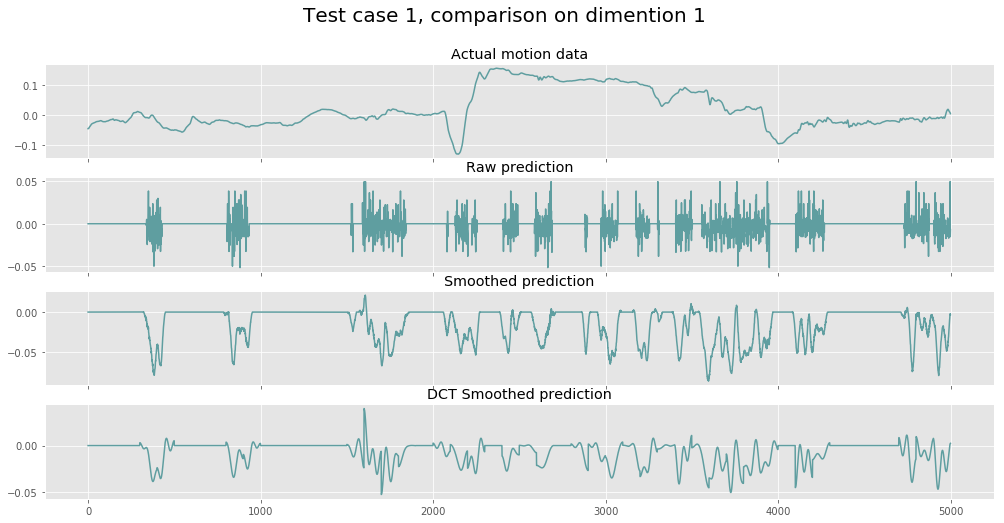

Error:    0.000245729119585
Motion length:  31983


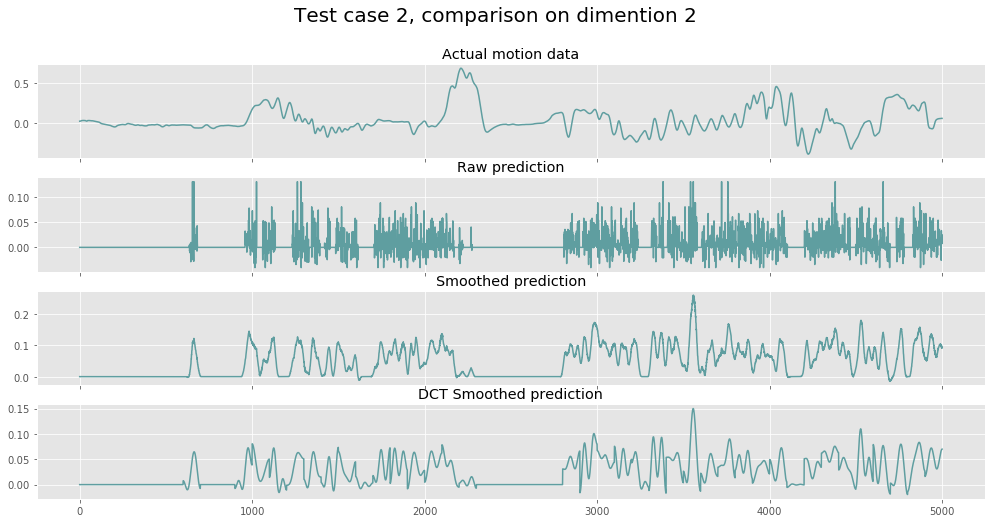

Error:    0.000243440782727
Motion length:  35331


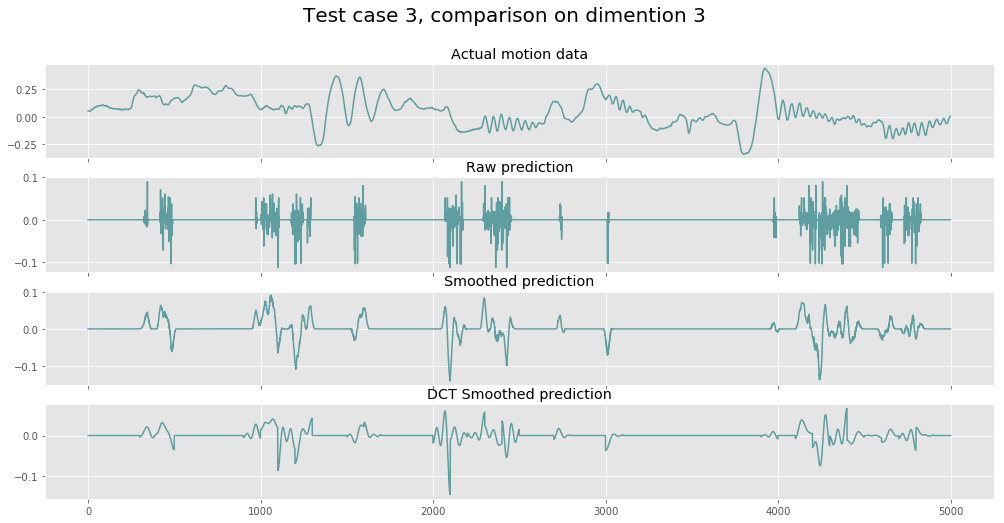

Error:    0.000249143338948
Motion length:  30155


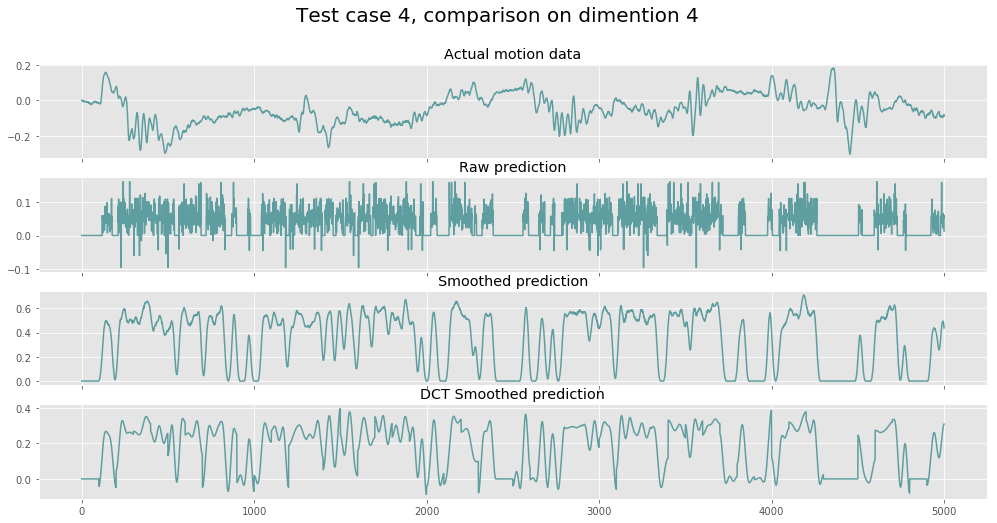

Error:    0.000131146773892
Motion length:  31798


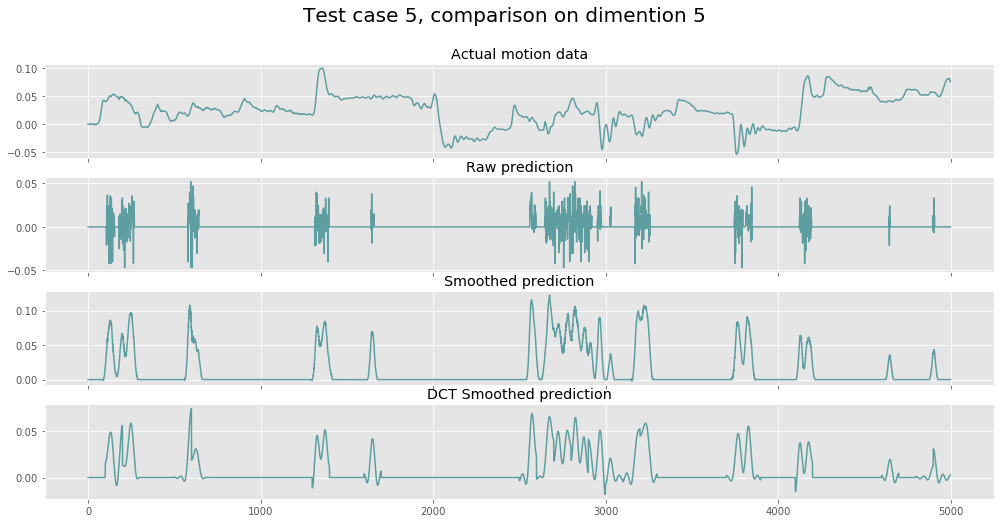

Error:    0.00199101950192
Motion length:  34518


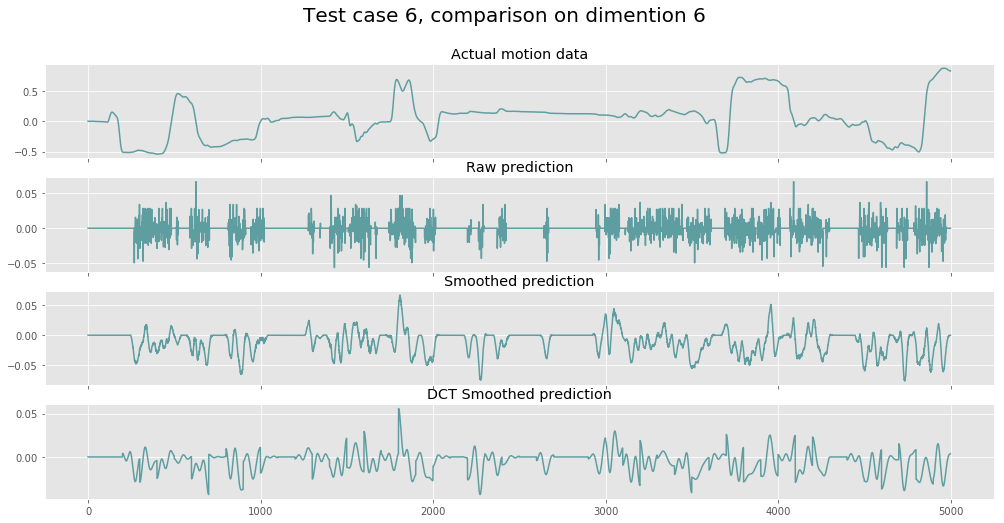

In [169]:
# Loop over 1-6 test cases

for i in range(1,7):
    test_data = HMSDataProvider('test{0}'.format(i), rng=rng)
    result, evaluation = optimiser.eval_test_set(test_data, 'test')
    print('Error:    ' + str(evaluation['errortest']))
    
    time_intervals = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(4, 6), dtype="int")
    prediction = np.zeros((time_intervals[-1,1] + 300, 6))
    counter = 0
    for line in time_intervals:
        for j in range(line[0], line[1]):
            prediction[j] = result[-1][counter]
            counter += 1
    prediction_smooth = smooth_prediction(prediction)
    prediction_dct_smooth = dct_smoothing(prediction, frequency_factor=5, window_size=100)
    prediction_dct_smooth *= 5

    np.savetxt('Predictions/extro_{0}.txt'.format(i), prediction, fmt="%.7f")
    np.savetxt('Predictions/extro_smooth_{0}.txt'.format(i), prediction_smooth, fmt="%.7f")
    np.savetxt('Predictions/extro_dct_{0}.txt'.format(i), prediction_dct_smooth, fmt="%.7f")
    
    motion_data = np.loadtxt("ExtrovertRawData/Motion/{0}.rov".format(i), skiprows=17, usecols=range(0, 6))
    print("Motion length: ", motion_data.shape[0])

    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(4, sharex=True, figsize=(17,8))
    axarr[0].plot(motion_data[:5000,i-1], color = 'cadetblue')
    axarr[0].set_title('Actual motion data')
    axarr[1].plot(prediction[:5000,i-1], color = 'cadetblue')
    axarr[1].set_title('Raw prediction')
    axarr[2].plot(prediction_smooth[:5000,i-1], color = 'cadetblue')
    axarr[2].set_title('Smoothed prediction')
    axarr[3].plot(prediction_dct_smooth[:5000,i-1], color = 'cadetblue')
    axarr[3].set_title('DCT Smoothed prediction')
    plt.suptitle('Test case {0}, comparison on dimention {1}'.format(i, i), size = 20)
    #plt.savefig('Predictions/Test case {0}, comparison on dimention {1}.pdf'.format(i, i))
    plt.show()